# ML project
TODO:
- More sophisticated graphs
- Test against other models

In [43]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
#from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from model_architecture import tft, training, val_dataloader, train_dataloader, validation, training

import matplotlib.pyplot as plt

In [44]:
# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

pl.seed_everything(42)

trainer = pl.Trainer(
    gpus=0,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
# Load the model
#savedTft = tft.load_from_checkpoint(torch.load('./app/lightning_logs/version_3/checkpoints/epoch=2-step=90.ckpt'))


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 32.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 16.1 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: 0it [00:00, ?it/s]

AttributeError: 'ExperimentWriter' object has no attribute 'add_figure'

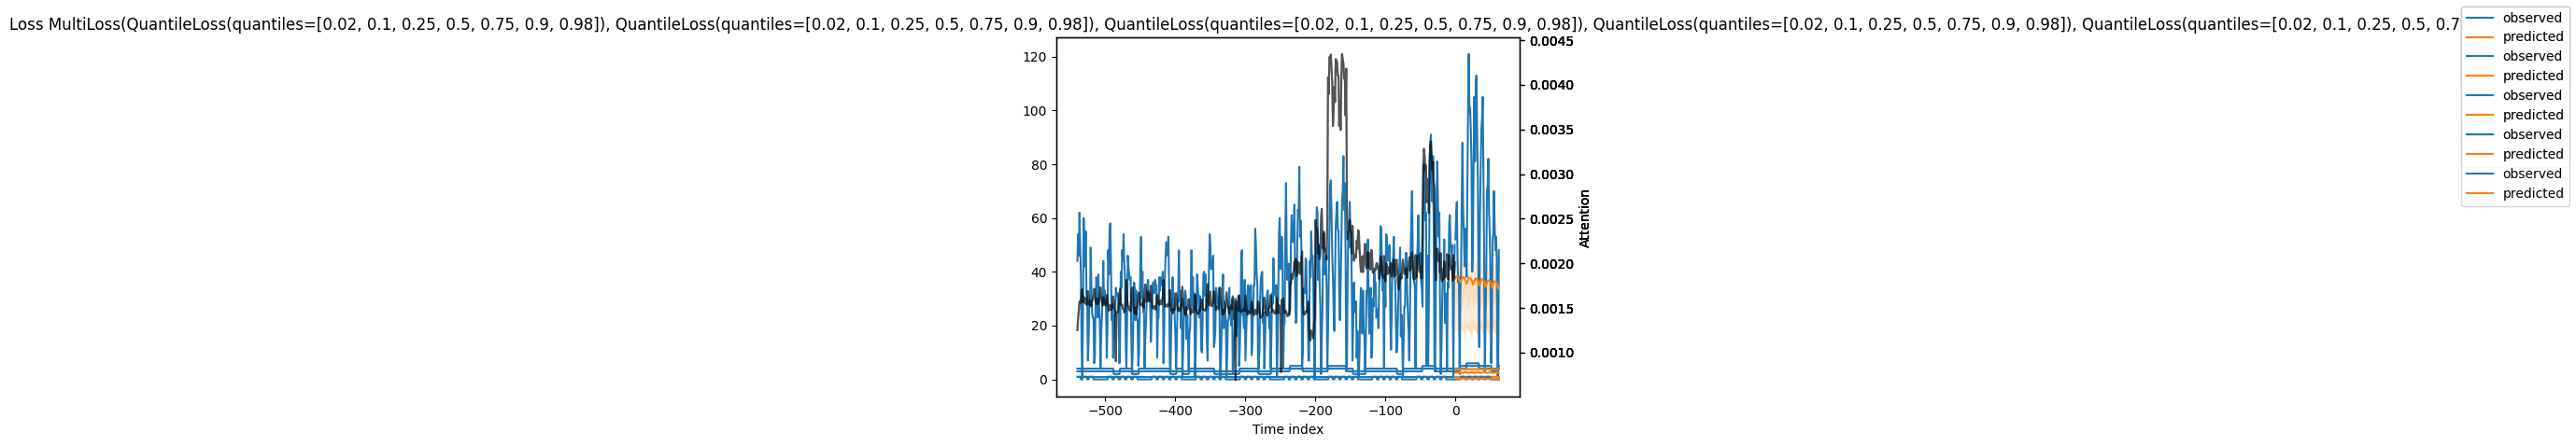

In [46]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)
#savedTft

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)

best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
#best_tft = savedTft # TODO: Comment out when retraining again

raw_prediction, x = best_tft.predict(
    #training.filter(lambda x: (x.constant_group == "group_1")),
    training,
    mode="raw",
    return_x=True,
)

: 

In [ ]:
# Save the temporal fusion transformer model
#torch.save(trainer.checkpoint_callback.best_model_path, './Saved_Models/bestCheckpoint1.pth')
#!zip  -r model.zip ./lightning_logs/version_3/*

: 

In [ ]:
# calcualte mean absolute error on validation set -> Only works for one output
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

: 

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True, show_progress_bar=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

: 

In [ ]:
#for idx in range(10):  # plot 10 examples 
best_tft.plot_prediction(x, raw_predictions, idx=0)


# plt.show only the first 200 samples
plt.xlim(-100, 80)
plt.show()

: 